# MBTI Classification by Keras : LSTM vs Transformer

The Myers-Briggs Type Indicator (MBTI) is one of the most widely-used personality tests. It classifies people into 16 4-letter categories. For more information on the MBTI, see: https://www.16personalities.com/personality-types

This dataset contains a person's Myers-Briggs type and the text of their online posts. So, can we use deep learning to predict someone's personality type based on what they write online?

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
PW = 8
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/lifeofpy/Desktop/MBTI'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/lifeofpy/Desktop/MBTI/mbti_1.csv


In [4]:
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv("/home/lifeofpy/Desktop/MBTI/mbti_1.csv")

In [6]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


The first thing I want to do is turn the personality types into numbered categories, ranging from 0 to 15. These will serve as the output of the model when it is categorizing people.

In [7]:
types = np.unique(data.type.values)

In [8]:
def get_type_index(string):
    return list(types).index(string)

In [9]:
data['type_index'] = data['type'].apply(get_type_index)

In [10]:
data.posts.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

## Data Preprocessing

Now, I want to clean the text to get rid of hyperlinks, puncuation, and anything else that's cluttering up the text. Specifically, the pipe (|) character seems like it separates different posts, but without spaces between them. First, I'm going to replace the pipes with spaces so that the tokenizer won't parse those parts as one long word. Then, I'll clean up the rest.

In [11]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words


In [12]:
data['cleaned_text'] = data['posts'].apply(clean_text)

In [13]:
data.cleaned_text.values[0]

'enfp  and  intj  moments  sportscenter  not  top  ten  plays  pranks  what  has  been  the  most  lifechanging  experience  in  your  life  on  repeat  for  most  of  today  may  the  perc  experience  immerse  you  the  last  thing  my  infj  friend  posted  on  his  facebook  before  committing  suicide  the  next  day  rest  in  peace  hello  enfj7  sorry  to  hear  of  your  distress  its  only  natural  for  a  relationship  to  not  be  perfection  all  the  time  in  every  moment  of  existence  try  to  figure  the  hard  times  as  times  of  growth  as  84389  84390    welcome  and  stuff  game  set  match  prozac  wellbrutin  at  least  thirty  minutes  of  moving  your  legs  and  i  dont  mean  moving  them  while  sitting  in  your  same  desk  chair  weed  in  moderation  maybe  try  edibles  as  a  healthier  alternative  basically  come  up  with  three  items  youve  determined  that  each  type  or  whichever  types  you  want  to  do  would  more  than  likely  us

In [14]:
data.head(10)

,type,posts,type_index,cleaned_text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,enfp and intj moments sportscenter not t...
1,ENTP,'I'm finding the lack of me in these posts ver...,3,im finding the lack of me in these pos...
2,INTP,'Good one _____ https://www.youtube.com/wat...,11,good one of course to which i say i ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,dear intp i enjoyed our conversation the...
4,ENTJ,'You're fired.|||That's another silly misconce...,2,youre fired thats another silly misconcep...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,10,1837 science is not perfect no scienti...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",8,no i cant draw on my own nails haha t...
7,INTJ,'I tend to build up a collection of things on ...,10,i tend to build up a collection of thi...
8,INFJ,"I'm not sure, that's a good question. The dist...",8,im not sure thats a good question the ...
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,11,im in this position where i have to ac...


In [13]:
data.nunique()

type              16
posts           8675
type_index        16
cleaned_text    8675
dtype: int64

In [14]:
data.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 1.0, 'Number of Users per MBTI Personality Type')

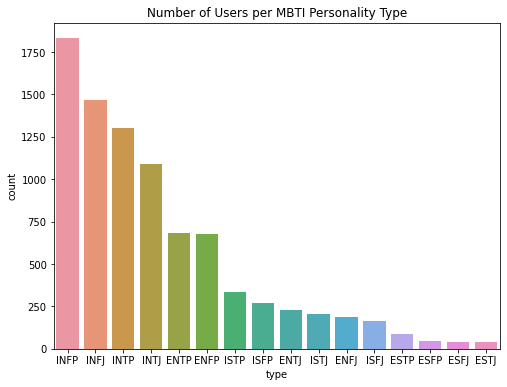

In [15]:
sns.countplot(x='type', data=data, order=data.type.value_counts().index).set_title('Number of Users per MBTI Personality Type')

In [16]:
# data.apply(lambda x: extract(x, posts), axis=1)

def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
data.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(data))
print("Number of posts", len(posts))

df = pd.DataFrame(posts, columns=["type", "posts"])

Number of users 8675
Number of posts 422845


/home/lifeofpy/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Post Lengths')

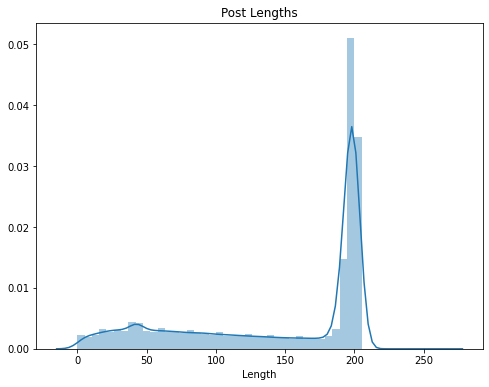

In [17]:
df['Length'] = df['posts'].apply(len)
sns.distplot(df['Length']).set_title('Post Lengths')

Now, we split the data into training, testing, and validation sets,

In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data)
# train, val = train_test_split(train)

Keras has a great tokenizer that we can use to turn sequences of words into arrays of numbers. For more information, see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data.cleaned_text.values)

In [20]:
maxlen = 1500
train_sequences = tokenizer.texts_to_sequences(train.cleaned_text.values)
train_padded = pad_sequences(train_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

test_sequences = tokenizer.texts_to_sequences(test.cleaned_text.values)
test_padded = pad_sequences(test_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

In [21]:
train_padded

array([[   2,  236,    4, ...,  260,    4,   68],
       [   2,   32,   45, ...,    0,    0,    0],
       [ 139, 1660,  104, ...,   33,    9,    3],
       ...,
       [   2,  698, 4988, ...,    0,    0,    0],
       [ 232,  340,    6, ...,    0,    0,    0],
       [  12,    3,  245, ...,    0,    0,    0]], dtype=int32)

## LSTM

So, our model is going to take in these arrays of numbers that represent the text, and it's going to output the personality type that it thinks is associated with it. Here, I'm going to convert the personality types to one-hot-encoded labels. This simply means that to represent a particular category, we make an array with the length of the total possible number of categories, and make all of the values zero except at the index of the category we're trying to represent. 

In [22]:
one_hot_labels = tf.keras.utils.to_categorical(train.type_index.values, num_classes=16)
test_labels= tf.keras.utils.to_categorical(test.type_index.values, num_classes=16)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D

def create_model():
    op = tf.keras.optimizers.Adam(learning_rate=0.00001)

    model = Sequential()
    model.add(Embedding(vocab_size, 256, input_length=maxlen-1))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(200, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(20)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])
    return model

In [27]:
model = create_model()
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1499, 256)         2560000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1499, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1499, 400)         731200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1499, 400)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                67360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [28]:
history = model.fit(train_padded, one_hot_labels, epochs = 30, verbose = 1)

Epoch 1/30
204/204 [==============================] - 48s 235ms/step - loss: 2.7550 - accuracy: 0.0875
Epoch 2/30
204/204 [==============================] - 49s 240ms/step - loss: 2.6723 - accuracy: 0.1283
Epoch 3/30
204/204 [==============================] - 49s 240ms/step - loss: 2.5332 - accuracy: 0.1499
Epoch 4/30
204/204 [==============================] - 49s 241ms/step - loss: 2.4529 - accuracy: 0.1855
Epoch 5/30
204/204 [==============================] - 50s 246ms/step - loss: 2.4003 - accuracy: 0.1943
Epoch 6/30
204/204 [==============================] - 49s 241ms/step - loss: 2.3777 - accuracy: 0.1998
Epoch 7/30
204/204 [==============================] - 49s 242ms/step - loss: 2.3694 - accuracy: 0.1978
Epoch 8/30
204/204 [==============================] - 49s 242ms/step - loss: 2.3583 - accuracy: 0.1970
Epoch 9/30
204/204 [==============================] - 50s 243ms/step - loss: 2.3500 - accuracy: 0.2000
Epoch 10/30
204/204 [==============================] - 49s 242ms/step - l

In [32]:
# get the best valid weight
# model.load_weights('model.weights.best.hdf5') 


# Test Accuracy
score = model.evaluate(test_padded, test_labels, verbose=1)

print("Test Accuracy: ", score[1])  # [0] : test loss, [1] : accuracy

68/68 [==============================] - 6s 94ms/step - loss: 2.2886 - accuracy: 0.1969
Test Accuracy:  0.19686491787433624


## Transformer

This model didn't do very well, only achieving around 20% accuracy. This is a difficult challenge- to classify people into 16 different categories based on text that may loosely correlate with those categories. Let's see if we can do a bit better by incorporating a transformer. I used the one from this Keras example: https://keras.io/examples/nlp/text_classification_with_transformer/

For more information about transformers in general, see: https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04

In [33]:
from tensorflow.keras import layers
from tensorflow import keras
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [34]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="elu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [35]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [36]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def create_model(): 
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(0.1)(x)
    x = (Bidirectional(LSTM(200, return_sequences=True)))(x)
    x = (Dropout(0.2))(x)
    x = (Bidirectional(LSTM(20)))(x)
    x = layers.Dense(20, activation="elu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(16, activation="softmax")(x)
    
    op = tf.keras.optimizers.Adam(learning_rate=0.00009)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(op, 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [37]:
model = create_model()
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500)]            0         
_________________________________________________________________
token_and_position_embedding (None, 1500, 32)          368000    
_________________________________________________________________
transformer_block (Transform (None, 1500, 32)          6464      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1500, 400)         372800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1500, 400)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40)                67360     
_________________________________________________________________
dense_10 (Dense)             (None, 20)               

In [38]:
history = model.fit(train_padded, one_hot_labels, epochs = 30, verbose = 1)

Epoch 1/30
204/204 [==============================] - 54s 264ms/step - loss: 2.5180 - accuracy: 0.1668
Epoch 2/30
204/204 [==============================] - 54s 267ms/step - loss: 2.3974 - accuracy: 0.1906
Epoch 3/30
204/204 [==============================] - 55s 267ms/step - loss: 2.3658 - accuracy: 0.1955
Epoch 4/30
204/204 [==============================] - 55s 268ms/step - loss: 2.3404 - accuracy: 0.1955
Epoch 5/30
204/204 [==============================] - 55s 268ms/step - loss: 2.3016 - accuracy: 0.2244
Epoch 6/30
204/204 [==============================] - 55s 268ms/step - loss: 2.2240 - accuracy: 0.2676
Epoch 7/30
204/204 [==============================] - 55s 268ms/step - loss: 2.0909 - accuracy: 0.3248
Epoch 8/30
204/204 [==============================] - 55s 268ms/step - loss: 1.9528 - accuracy: 0.3875
Epoch 9/30
204/204 [==============================] - 55s 268ms/step - loss: 1.8224 - accuracy: 0.4417
Epoch 10/30
204/204 [==============================] - 55s 268ms/step - l

In [39]:
# Test Accuracy
score = model.evaluate(test_padded, test_labels, verbose=1)

print("Test Accuracy: ", score[1])  # [0] : test loss, [1] : accuracy

68/68 [==============================] - 7s 107ms/step - loss: 3.5730 - accuracy: 0.2909
Test Accuracy:  0.2909174859523773
